参照资料：https://blog.csdn.net/weixin_47440593/article/details/107721334?utm_source=app

到目前为止，我们一直在使用numpy来自己编写神经网络。在本章中我们将一步步使用深度学习框架来构建属于自己的神经网络。现在我们将学习TensorFlow这个框架：
- 初始化变量
- 建立一个会话
- 训练的算法
- 实现一个神经网络

版本说明：
- python：3.9
- TensorFlow：2.9.1

# 1 - Exploring the Tensorflow Library

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import tf_utils
import time
np.random.seed(1)

我们现在已经导入了相关的库，我们将引导你完成不同的应用，现在我们来看一下计算的损失公式
![](images/loss.png)

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()           #保证session.run()能够正常运行
y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39
 
loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss
init = tf.compat.v1.global_variables_initializer()         # When init is run later (session.run(init)),                                    # the loss variable will be initialized and ready to be computed
with tf.compat.v1.Session () as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))

9


对于Tensoflow的代码实现而言，实现代码结构如下：
- 创建Tensorflow变量（此时，尚未直接计算）
- 实现Tensorflow变量之间的操作定义
- 初始化Tensorflow变量
- 创建Session
- 运行Session

因此，当我们为损失函数创建一个变量时，我们简单地将损失定义为其他数量的函数，但没有评估它的价值。 为了评估它，我们需要运行init = tf.compat.v1.global_variables_initializer()

In [3]:
a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
 
print(c)

Tensor("Mul:0", shape=(), dtype=int32)


正如预料中一样，我们并没有看到结果20，不过我们得到了一个Tensor类型的变量，没有维度，数字类型为int32。我们之前所做的一切都只是把这些东西放到了一个“计算图(computation graph)”中，而我们还没有开始运行这个计算图，为了实际计算这两个数字，我们需要创建一个会话并运行它

In [4]:
sess = tf.compat.v1.Session ()
 
print(sess.run(c))

20


总结一下，记得初始化变量，然后创建一个sessio来运行它

接下来，我们需要了解一下占位符（placeholders）。占位符是一个对象，它的值只能在稍后指定，要指定占位符的值，可以使用一个feed字典（feed_dict变量）来传入，接下来，我们为x创建一个占位符，这将允许我们在稍后运行会话时传入一个数字

In [5]:
#利用feed_dict来改变x的值
 
x = tf.compat.v1.placeholder(tf.int64,name="x")
print(sess.run(2 * x,feed_dict={x:3}))
sess.close()

6


当我们第一次定义x时，我们不必为它指定一个值。 占位符只是一个变量，我们会在运行会话时将数据分配给它

## 1.1 - Linear function

让我们通过计算以下等式来开始编程 Y = WX +b,W和X是随机矩阵，b是随机向量

我们计算WX+b,其中W,X和b是从随机正态分布中抽取的。W的维度是（4,3），X是（3,1），b是（4,1）。 我们开始定义一个shape=（3,1）的常量X：`X = tf.constant(np.random.randn(3,1), name = "X")`

In [6]:
def linear_function():
    """
    实现一个线性功能：
        初始化W，类型为tensor的随机变量，维度为(4,3)
        初始化X，类型为tensor的随机变量，维度为(3,1)
        初始化b，类型为tensor的随机变量，维度为(4,1)
    返回：
        result - 运行了session后的结果，运行的是Y = WX + b 
    
    """
    
    np.random.seed(1) #指定随机种子
    
    X = np.random.randn(3,1)
    W = np.random.randn(4,3)
    b = np.random.randn(4,1)
    
    Y = tf.add(tf.matmul(W,X),b) #tf.matmul是矩阵乘法
    #Y = tf.matmul(W,X) + b #也可以以写成这样子
    
    #创建一个session并运行它
    sess = tf.compat.v1.Session ()#这里也是一样的原因和上文
    result = sess.run(Y)
    
    #session使用完毕，关闭它
    sess.close()
    
    return result

In [7]:
print("result = " +  str(linear_function()))

result = [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


## 1.2 - Computing the sigmoid

我们已经实现了线性函数，TensorFlow提供了多种常用的神经网络的函数比如tf.softmax和 tf.sigmoid

我们将使用占位符变量x，当运行这个session的时候，我们西药使用使用feed字典来输入z，我们将创建占位符变量x，使用tf.sigmoid来定义操作符，最后运行session，我们会用到下面的代码：
- tf.placeholder(tf.float32, name = “…”)
- tf.sigmoid(…)
- sess.run(…, feed_dict = {x: z})

需要注意的是，我们可以使用两种方式来创建并使用session

方法一：
```
sess = tf.Session()
result = sess.run(...,feed_dict = {...})
sess.close()
```
方法二：
```
with tf.Session as sess:
    result = sess.run(...,feed_dict = {...})
```

In [8]:
def sigmoid(z):
    """
    实现使用sigmoid函数计算z
    
    参数：
        z - 输入的值，标量或矢量
    
    返回：
        result - 用sigmoid计算z的值
    
    """
    
    #创建一个占位符x，名字叫“x”
    x = tf.compat.v1.placeholder(tf.float32,name="x")
    
    #计算sigmoid(z)
    sigmoid = tf.sigmoid(x)
    
    #创建一个会话，使用方法二
    with tf.compat.v1.Session () as sess:
        result = sess.run(sigmoid,feed_dict={x:z})
        
    return result

In [9]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.99999386


## 1.3 - Computing the Cost

![](images/Computing_cost.png)

In [10]:
# GRADED FUNCTION: cost

def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    ### START CODE HERE ### 
    
    # Create the placeholders for "logits" (z) and "labels" (y) (approx. 2 lines)
    z = tf.compat.v1.placeholder(tf.float32, name="z")
    y = tf.compat.v1.placeholder(tf.float32, name="y")
    
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    
    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.compat.v1.Session()
    
    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict={z: logits, y: labels})
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return cost

In [11]:
logits = sigmoid(np.array([0.2, 0.4, 0.7, 0.9]))
cost = cost(logits, np.array([0, 0, 1, 1]))
print ("cost = " + str(cost))

cost = [1.0053873  1.0366408  0.41385433 0.39956617]


## 1.4 - Using One Hot encodings

很多时候在深度学习中y yy向量的维度是从0到C−1的C是指分类的类别数量，如果C=4，那么对y而言你可能需要有以下的转换方式:
![](images/onehot.png)

这叫做独热编码（“one hot” encoding），因为在转换后的表示中，每列的一个元素是“hot”（意思是设置为1）。 要在numpy中进行这种转换，您可能需要编写几行代码。 在tensorflow中，只需要使用一行代码：`tf.one_hot(labels,depth,axis)`

In [12]:
def one_hot_matrix(lables,C):
    """
    创建一个矩阵，其中第i行对应第i个类号，第j列对应第j个训练样本
    所以如果第j个样本对应着第i个标签，那么entry (i,j)将会是1
    
    参数：
        lables - 标签向量
        C - 分类数
        
    返回：
        one_hot - 独热矩阵
    
    """
    
    #创建一个tf.constant，赋值为C，名字叫C
    C = tf.constant(C,name="C")
    
    #使用tf.one_hot，注意一下axis
    one_hot_matrix = tf.one_hot(indices=lables , depth=C , axis=0)
    
    #创建一个session
    sess =tf.compat.v1.Session () 
    
    #运行session
    one_hot = sess.run(one_hot_matrix)
    
    #关闭session
    sess.close()
    
    return one_hot

In [13]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels,C=4)
print(str(one_hot))

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


## 1.5 - Initialize with zeros and ones

现在我们将学习如何用0或者1初始化一个向量，我们要用到tf.ones()和tf.zeros()，给定这些函数一个维度值那么它们将会返回全是1或0的满足条件的向量/矩阵，我们来看看怎样实现它们：

In [14]:
def ones(shape):
    """
    创建一个维度为shape的变量，其值全为1
    
    参数：
        shape - 你要创建的数组的维度
    
    返回：
        ones - 只包含1的数组    
    """
    
    #使用tf.ones()
    ones = tf.ones(shape)
    
    #创建会话
    sess = tf.compat.v1.Session () 
    #运行会话
    ones = sess.run(ones)
    
    #关闭会话
    sess.close()
    
    return ones

In [15]:
print ("ones = " + str(ones([3])))

ones = [1. 1. 1.]


## 2 - Building your first neural network in tensorflow

我们将会使用TensorFlow构建一个神经网络，需要记住的是实现模型需要做以下两个步骤：
- 创建计算图
- 运行计算图

## 2.0 - Problem statement: SIGNS Dataset

一天下午，我们和一些朋友决定教我们的电脑破译手语。我们花了几个小时在白色的墙壁前拍照，于是就有了了以下数据集。现在，你的任务是建立一个算法，使有语音障碍的人与不懂手语的人交流
- 训练集：有从0到5的数字的1080张图片(64x64像素)，每个数字拥有180张图片
- 测试集：有从0到5的数字的120张图片(64x64像素)，每个数字拥有5张图片

需要注意的是这是完整数据集的一个子集，完整的数据集包含更多的符号。

下面是每个数字的样本，以及我们如何表示标签的解释。这些都是原始图片，我们实际上用的是64 * 64像素的图片
![](images/hands.png)

首先加载数据集

In [16]:
#构建网络
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()#加载数据集

Y = 5


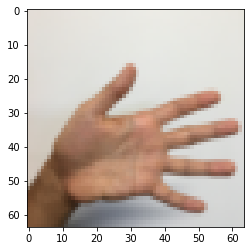

In [17]:
index = 0
plt.imshow(X_train_orig[index])
print("Y = " + str(np.squeeze(Y_train_orig[:,index])))

和往常一样，我们要对数据集进行扁平化，然后再除以255以归一化数据，除此之外，我们要需要把每个标签转化为独热向量，像上面的图一样

In [18]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T #每一列就是一个样本
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
 
#归一化数据
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255
 
#转换为独热矩阵
Y_train = tf_utils.convert_to_one_hot(Y_train_orig,6)
Y_test = tf_utils.convert_to_one_hot(Y_test_orig,6)
 
print("训练集样本数 = " + str(X_train.shape[1]))
print("测试集样本数 = " + str(X_test.shape[1]))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

训练集样本数 = 1080
测试集样本数 = 120
X_train.shape: (12288, 1080)
Y_train.shape: (6, 1080)
X_test.shape: (12288, 120)
Y_test.shape: (6, 120)


我们的目标是构建能够高准确度识别符号的算法。 要做到这一点，你要建立一个TensorFlow模型，这个模型几乎和你之前在猫识别中使用的numpy一样（但现在使用softmax输出）。要将您的numpy实现与tensorflow实现进行比较的话这是一个很好的机会

目前的模型是：LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX，SIGMOID输出层已经转换为SOFTMAX。当有两个以上的类时，一个SOFTMAX层将SIGMOID一般化

## 2.1 - Create placeholders

我们的第一项任务是为X和Y创建占位符，这将允许我们稍后在运行会话时传递您的训练数据

In [19]:
def create_placeholders(n_x,n_y):
    """
    为TensorFlow会话创建占位符
    参数：
        n_x - 一个实数，图片向量的大小（64*64*3 = 12288）
        n_y - 一个实数，分类数（从0到5，所以n_y = 6）
    
    返回：
        X - 一个数据输入的占位符，维度为[n_x, None]，dtype = "float"
        Y - 一个对应输入的标签的占位符，维度为[n_Y,None]，dtype = "float"
    
    提示：
        使用None，因为它让我们可以灵活处理占位符提供的样本数量。事实上，测试/训练期间的样本数量是不同的。
    
    """
    
    X = tf.compat.v1.placeholder(tf.float32, [n_x, None], name="X")#这里注意下tf版本，和原博客不一致
    Y = tf.compat.v1.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [20]:
X, Y = create_placeholders(12288, 6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_4:0", shape=(12288, None), dtype=float32)
Y = Tensor("Y_2:0", shape=(6, None), dtype=float32)


## 2.2 Initializing the parameters

初始化tensorflow中的参数，我们将使用Xavier初始化权重和用零来初始化偏差，比如：

In [21]:
W1 = tf.compat.v1.get_variable("W1", [25,12288],initializer = tf.initializers.GlorotUniform(seed=1))
b1 = tf.compat.v1.get_variable("b1", [25,1], initializer = tf.zeros_initializer())

注：tf.Variable() 每次都在创建新对象，对于get_variable()来说，对于已经创建的变量对象，就把那个对象返回，如果没有创建变量对象的话，就创建一个新的

In [22]:
def initialize_parameters():
    """
    初始化神经网络的参数，参数的维度如下：
        W1 : [25, 12288]
        b1 : [25, 1]
        W2 : [12, 25]
        b2 : [12, 1]
        W3 : [6, 12]
        b3 : [6, 1]
    
    返回：
        parameters - 包含了W和b的字典
    
    
    """
    tf.random.set_seed(1)
    #tf.set_random_seed(1) #指定随机种子
    
    W1 = tf.compat.v1.get_variable("W1",[25,12288],initializer = tf.initializers.GlorotUniform(seed=1))
   # W1 = tf.compat.v1.get_variable("W1",[25,12288],initializer=tf.layers.xavier_initializer(seed=1))
    b1 = tf.compat.v1.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.compat.v1.get_variable("W2", [12, 25], initializer = tf.initializers.GlorotUniform(seed=1))
    #W2 = tf.compat.v1.get_variable("W2", [12, 25], initializer = tf.layers.xavier_initializer(seed=1))
    b2 = tf.compat.v1.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3", [6, 12], initializer = tf.initializers.GlorotUniform(seed=1))
    #W3 = tf.compat.v1.get_variable("W3", [6, 12], initializer = tf.layers.xavier_initializer(seed=1))
    b3 = tf.compat.v1.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [23]:
ops.reset_default_graph() #用于清除默认图形堆栈并重置全局默认图形。 
 
with tf.compat.v1.Session ()  as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32>


正如预期的那样，这些参数只有物理空间，但是还没有被赋值，这是因为没有通过session执行

## 2.3 - 前向传播

我们将要在TensorFlow中实现前向传播，该函数将接受一个字典参数并完成前向传播，它会用到以下代码
- tf.add(…) ：加法
- tf.matmul(… , …) ：矩阵乘法
- tf.nn.relu(…) ：Relu激活函数

我们要实现神经网络的前向传播，我们会拿numpy与TensorFlow实现的神经网络的代码作比较。最重要的是前向传播要在Z3处停止，因为在TensorFlow中最后的线性输出层的输出作为计算损失函数的输入，所以不需要A3

In [24]:
def forward_propagation(X,parameters):
    """
    实现一个模型的前向传播，模型结构为LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    参数：
        X - 输入数据的占位符，维度为（输入节点数量，样本数量）
        parameters - 包含了W和b的参数的字典
    
    返回：
        Z3 - 最后一个LINEAR节点的输出
    
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)        # Z1 = np.dot(W1, X) + b1
    #Z1 = tf.matmul(W1,X) + b1             #也可以这样写
    A1 = tf.nn.relu(Z1)                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)     # Z3 = np.dot(W3,Z2) + b3
    
    
    return Z3

In [25]:
ops.reset_default_graph() #用于清除默认图形堆栈并重置全局默认图形。 
with tf.compat.v1.Session ()  as sess:
    X,Y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, None), dtype=float32)


你可能已经注意到前向传播不会输出任何cache，当我们完成反向传播的时候你就会明白了

## 2.4 - Compute cost

如前所述，成本很容易计算：

`tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))`

In [26]:
def compute_cost(Z3,Y):
    """
    计算成本
    
    参数：
        Z3 - 前向传播的结果
        Y - 标签，一个占位符，和Z3的维度相同
        
    返回：
        cost - 成本值
    
    
    """
    logits = tf.transpose(Z3) #转置
    labels = tf.transpose(Y)  #转置
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [27]:
ops.reset_default_graph()
 
with tf.compat.v1.Session () as sess:
    X,Y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


## 2.5 - Backward propagation & parameter updates

得益于编程框架，所有反向传播和参数更新都在1行代码中处理。计算成本函数后，将创建一个“optimizer”对象。 运行tf.session时，必须将此对象与成本函数一起调用，当被调用时，它将使用所选择的方法和学习速率对给定成本进行优化

对于梯度下降：` 
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
 `
 
 优化：
 `_ , c = sess.run([optimizer,cost],feed_dict={X:mini_batch_X,Y:mini_batch_Y})`
 
 编写代码时，我们经常使用 _ 作为一次性变量来存储我们稍后不需要使用的值。 这里，_ 具有我们不需要的优化器的评估值（并且c取值为成本变量的值）

## 2.6 - Building the model

In [28]:
def model(X_train,Y_train,X_test,Y_test,
		learning_rate=0.0001,num_epochs=1500,minibatch_size=32,
		print_cost=True,is_plot=True):
    """
    实现一个三层的TensorFlow神经网络：LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
    
    参数：
        X_train - 训练集，维度为（输入大小（输入节点数量） = 12288, 样本数量 = 1080）
        Y_train - 训练集分类数量，维度为（输出大小(输出节点数量) = 6, 样本数量 = 1080）
        X_test - 测试集，维度为（输入大小（输入节点数量） = 12288, 样本数量 = 120）
        Y_test - 测试集分类数量，维度为（输出大小(输出节点数量) = 6, 样本数量 = 120）
        learning_rate - 学习速率
        num_epochs - 整个训练集的遍历次数
        mini_batch_size - 每个小批量数据集的大小
        print_cost - 是否打印成本，每100代打印一次
        is_plot - 是否绘制曲线图
    
    返回：
        parameters - 学习后的参数
    """
    ops.reset_default_graph() #能够重新运行模型而不覆盖tf变量
    tf.random.set_seed(1)
    #tf.set_random_seed(1)
    seed = 3
    (n_x , m)  = X_train.shape               #获取输入节点数量和样本数
    n_y = Y_train.shape[0]                   #获取输出节点数量
    costs = []                               #成本集
    
    #给X和Y创建placeholder
    X,Y = create_placeholders(n_x,n_y)
    
    #初始化参数
    parameters = initialize_parameters()
    
    #前向传播
    Z3 = forward_propagation(X,parameters)
    
    #计算成本
    cost = compute_cost(Z3,Y)
    
    #反向传播，使用Adam优化
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #初始化所有的变量
    init = tf.compat.v1.global_variables_initializer()
    
    #开始会话并计算
    with tf.compat.v1.Session () as sess:
        #初始化
        sess.run(init)
        
        #正常训练的循环
        for epoch in range(num_epochs):
            
            epoch_cost = 0  #每代的成本
            num_minibatches = int(m / minibatch_size)    #minibatch的总数量
            seed = seed + 1
            minibatches = tf_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                
                #选择一个minibatch
                (minibatch_X,minibatch_Y) = minibatch
                
                #数据已经准备好了，开始运行session
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                #计算这个minibatch在这一代中所占的误差
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches
                
            #记录并打印成本
            ## 记录成本
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                #是否打印：
                if print_cost and epoch % 100 == 0:
                        print("epoch = " + str(epoch) + "    epoch_cost = " + str(epoch_cost))
        
        #是否绘制图谱
        if is_plot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
        
        #保存学习后的参数
        parameters = sess.run(parameters)
        print("参数已经保存到session。")
        
        #计算当前的预测结果
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        
        #计算准确率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        
        print("训练集的准确率：", accuracy.eval({X: X_train, Y: Y_train}))
        print("测试集的准确率:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

epoch = 0    epoch_cost = 1.8557019233703613
epoch = 100    epoch_cost = 1.0172552105152244
epoch = 200    epoch_cost = 0.7331837388602169
epoch = 300    epoch_cost = 0.5730706489447391
epoch = 400    epoch_cost = 0.4685733806003224
epoch = 500    epoch_cost = 0.3812274485826493
epoch = 600    epoch_cost = 0.31381534401214484
epoch = 700    epoch_cost = 0.25370787445342907
epoch = 800    epoch_cost = 0.2038999405322653
epoch = 900    epoch_cost = 0.16645333216045843
epoch = 1000    epoch_cost = 0.1466356863578161
epoch = 1100    epoch_cost = 0.10727914592081851
epoch = 1200    epoch_cost = 0.08669911110491461
epoch = 1300    epoch_cost = 0.059341195744998534
epoch = 1400    epoch_cost = 0.05228919930981866


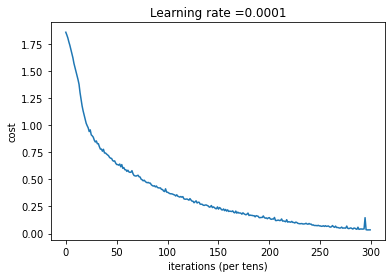

参数已经保存到session。
训练集的准确率： 0.9990741
测试集的准确率: 0.725
CPU的执行时间 = 172.773842 秒


In [29]:
#开始时间
start_time = time.perf_counter() 
#开始训练
parameters = model(X_train, Y_train, X_test, Y_test)
#结束时间
end_time = time.perf_counter() 
#计算时差
print("CPU的执行时间 = " + str(end_time - start_time) + " 秒" )

## 2.7 - Test with your own image (optional / ungraded exercise)

博主自己拍了5张图片，然后裁剪成1：1的样式，再通过格式工厂把很大的图片缩放成64x64的图片，同时把jpg转化为png，因为mpimg只能读取png的图片

Instructions for updating:
non-resource variables are not supported in the long term
预测结果: y = 1


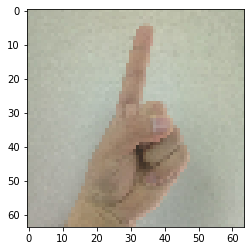

In [30]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
#这是博主自己拍的图片
my_image1 = "1.png"                                            #定义图片名称
fileName1 = "C:/Users/20919/PycharmProjects/wuenda-DeepLearning/Improve deep neural networks/Tensorflow Tutorial/datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)#显示图片
from skimage import transform 
image1=transform.resize(image1,(64,64,3)).reshape(64*64*3,1)#这个图片的size不是很合适，调一下
my_image1 = image1.reshape(1,64 * 64 * 3).T                    #重构图片
my_image_prediction = tf_utils.predict(my_image1, parameters)  #开始预测
print("预测结果: y = " + str(np.squeeze(my_image_prediction)))

预测结果: y = 1


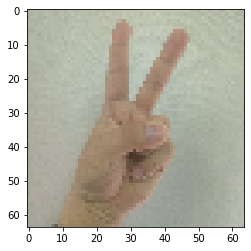

In [31]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
#这是博主自己拍的图片
my_image1 = "2.png"                                            #定义图片名称
fileName1 = "C:/Users/20919/PycharmProjects/wuenda-DeepLearning/Improve deep neural networks/Tensorflow Tutorial/datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)#显示图片
from skimage import transform 
image1=transform.resize(image1,(64,64,3)).reshape(64*64*3,1)#这个图片的size不是很合适，调一下
my_image1 = image1.reshape(1,64 * 64 * 3).T                    #重构图片
my_image_prediction = tf_utils.predict(my_image1, parameters)  #开始预测
print("预测结果: y = " + str(np.squeeze(my_image_prediction)))

预测结果: y = 2


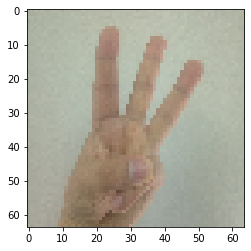

In [32]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
#这是博主自己拍的图片
my_image1 = "3.png"                                            #定义图片名称
fileName1 = "C:/Users/20919/PycharmProjects/wuenda-DeepLearning/Improve deep neural networks/Tensorflow Tutorial/datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)#显示图片
from skimage import transform 
image1=transform.resize(image1,(64,64,3)).reshape(64*64*3,1)#这个图片的size不是很合适，调一下
my_image1 = image1.reshape(1,64 * 64 * 3).T                    #重构图片
my_image_prediction = tf_utils.predict(my_image1, parameters)  #开始预测
print("预测结果: y = " + str(np.squeeze(my_image_prediction)))

预测结果: y = 2


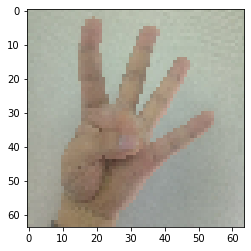

In [33]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
#这是博主自己拍的图片
my_image1 = "4.png"                                            #定义图片名称
fileName1 = "C:/Users/20919/PycharmProjects/wuenda-DeepLearning/Improve deep neural networks/Tensorflow Tutorial/datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)#显示图片
from skimage import transform 
image1=transform.resize(image1,(64,64,3)).reshape(64*64*3,1)#这个图片的size不是很合适，调一下
my_image1 = image1.reshape(1,64 * 64 * 3).T                    #重构图片
my_image_prediction = tf_utils.predict(my_image1, parameters)  #开始预测
print("预测结果: y = " + str(np.squeeze(my_image_prediction)))

预测结果: y = 5


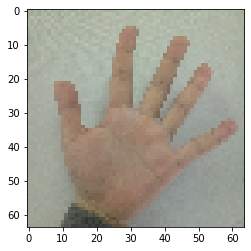

In [34]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
#这是博主自己拍的图片
my_image1 = "5.png"                                            #定义图片名称
fileName1 = "C:/Users/20919/PycharmProjects/wuenda-DeepLearning/Improve deep neural networks/Tensorflow Tutorial/datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)#显示图片
from skimage import transform 
image1=transform.resize(image1,(64,64,3)).reshape(64*64*3,1)#这个图片的size不是很合适，调一下
my_image1 = image1.reshape(1,64 * 64 * 3).T                    #重构图片
my_image_prediction = tf_utils.predict(my_image1, parameters)  #开始预测
print("预测结果: y = " + str(np.squeeze(my_image_prediction)))

看的出来，模型还有很大的改进空间，人工智障石锤了